# Predicting amazon stock price with LSTM

### Extract stock market data for Amazon from YAHOO Finance

In [128]:
import findspark
findspark.init()
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession

In [129]:
#For this we use the Yahoo finance page, we download the CSV file with the daily information with the price of 
#Amazon shares from 2000 to 2021
spark = SparkSession.builder \
    .master("local") \
    .appName("StockMarket") \
    .config("spark.executor.memory", "6gb") \
    .getOrCreate()

#### We create the spark dataframe with the CSV file with the daily information of Amazon shares

In [130]:
df =spark.read.format('com.databricks.spark.csv')\
   .options(header='true', inferschema='true')\
   .load('AMZN.csv')

In [131]:
df.show()

+----------+-------+-------+---------+-------+---------+--------+
|      Date|   Open|   High|      Low|  Close|Adj Close|  Volume|
+----------+-------+-------+---------+-------+---------+--------+
|2000-01-03|   81.5|89.5625|79.046875| 89.375|   89.375|16117600|
|2000-01-04| 85.375|   91.5|    81.75|81.9375|  81.9375|17487400|
|2000-01-05|   70.5| 75.125|     68.0|  69.75|    69.75|38457400|
|2000-01-06|71.3125|72.6875|     64.0|65.5625|  65.5625|18752000|
|2000-01-07|   67.0|   70.5|  66.1875|69.5625|  69.5625|10505400|
|2000-01-10|72.5625| 72.625|  65.5625|69.1875|  69.1875|14757900|
|2000-01-11| 66.875|   70.0|     65.0|  66.75|    66.75|10532700|
|2000-01-12| 67.875|   68.0|     63.0|63.5625|  63.5625|10804500|
|2000-01-13|64.9375|67.1875|   63.125|65.9375|  65.9375|10448100|
|2000-01-14|  66.75| 68.625|     64.0|  64.25|    64.25| 6853600|
|2000-01-18|63.4375|65.1875|     63.0| 64.125|   64.125| 5384900|
|2000-01-19| 64.125|   67.5|     63.0|66.8125|  66.8125| 8245500|
|2000-01-2

### Exploring and visualizing stock market data for Amazon

In [132]:
import pyspark.sql.functions as func

In [133]:
df = df.withColumn('date', func.to_date('Date'))

In [134]:
#we want to extract the day, month, and year from the date column
#we can split the date by a hyphen and then adding a new column for the year, month, and day using the withColumn() function.
date_breakdown = ['year', 'month', 'day']
for i in enumerate(date_breakdown):
    index = i[0]
    name = i[1]
    df = df.withColumn(name, func.split('date', '-')[index])

In [135]:
df.show(n=15)

+----------+-------+-------+---------+-------+---------+--------+----+-----+---+
|      date|   Open|   High|      Low|  Close|Adj Close|  Volume|year|month|day|
+----------+-------+-------+---------+-------+---------+--------+----+-----+---+
|2000-01-03|   81.5|89.5625|79.046875| 89.375|   89.375|16117600|2000|   01| 03|
|2000-01-04| 85.375|   91.5|    81.75|81.9375|  81.9375|17487400|2000|   01| 04|
|2000-01-05|   70.5| 75.125|     68.0|  69.75|    69.75|38457400|2000|   01| 05|
|2000-01-06|71.3125|72.6875|     64.0|65.5625|  65.5625|18752000|2000|   01| 06|
|2000-01-07|   67.0|   70.5|  66.1875|69.5625|  69.5625|10505400|2000|   01| 07|
|2000-01-10|72.5625| 72.625|  65.5625|69.1875|  69.1875|14757900|2000|   01| 10|
|2000-01-11| 66.875|   70.0|     65.0|  66.75|    66.75|10532700|2000|   01| 11|
|2000-01-12| 67.875|   68.0|     63.0|63.5625|  63.5625|10804500|2000|   01| 12|
|2000-01-13|64.9375|67.1875|   63.125|65.9375|  65.9375|10448100|2000|   01| 13|
|2000-01-14|  66.75| 68.625|

In [136]:
#Spark dataframes are more limited in visualization features than pandas dataframes. 
#Therefore, we will subset two columns "year" and "Adj Close" from the Spark dataframe and convert them into a pandas dataframe

df_plot = df.select('year', 'Adj Close').toPandas()

In [137]:
df_plot.head(10)

,year,Adj Close
0,2000,89.3750
1,2000,81.9375
2,2000,69.7500
3,2000,65.5625
4,2000,69.5625
5,2000,69.1875
6,2000,66.7500
7,2000,63.5625
8,2000,65.9375
9,2000,64.2500


In [138]:
from matplotlib import pyplot as plt


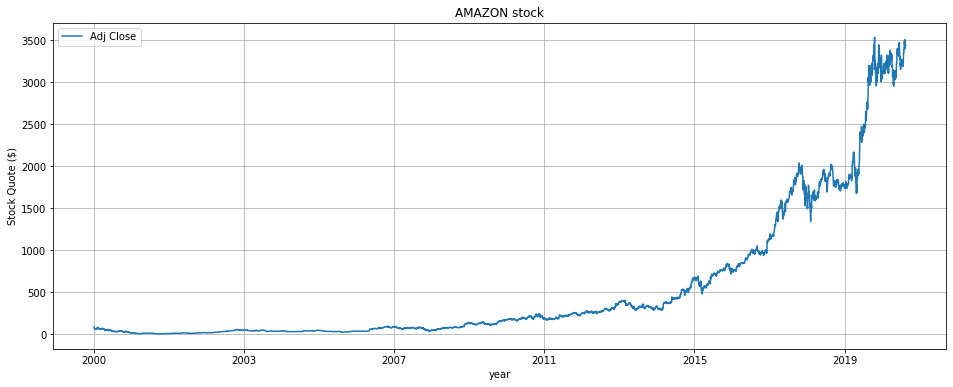

In [139]:
#The pandas dataframe, df_plot, is ready to be plotted using matplotlib
%matplotlib inline

df_plot.set_index('year', inplace=True)
df_plot.plot(figsize=(16, 6), grid=True)
plt.title('AMAZON stock')
plt.ylabel('Stock Quote ($)')
plt.show()

#### Amazon has had constant growth in the last 20 years, although its greatest growth has been from 2015 to the present. It can be noted that from 2019 to 2021 there has been an exponential growth in the price of shares, although in this last year has been an oscillation in these prices is equally noticeable, perhaps due to the pandemic.

In [140]:
df.toPandas().shape

(5408, 10)

In [141]:
#we can see that the row count is still 4,610, which is identical to the row count from the previous step, 
#indicating that none of the rows have any null values.

df.dropna().count()

5408

In [142]:
#Finally, we can get a good read on the row count, mean, standard deviation, minimum, and maximum values of each of the 
#columns that will be used in the model.This can help to identify whether there are anomalies in the data. 
#One important thing to note is that each of the five fields that will be used in the model has a standard deviation 
#higher than the mean value, indicating that the data is more spread out and not so clustered around the mean. 

df.select('Open', 'High', 'Low', 'Close', 'Adj Close').describe().show()

+-------+-----------------+-----------------+-----------------+-----------------+-----------------+
|summary|             Open|             High|              Low|            Close|        Adj Close|
+-------+-----------------+-----------------+-----------------+-----------------+-----------------+
|  count|             5408|             5408|             5408|             5408|             5408|
|   mean|535.8981692821749|541.7467842855041|529.3981465336542|535.7620004197496|535.7620004197496|
| stddev|822.9195087113982|831.6190258530577|812.9042526684628|822.3170578510645|822.3170578510645|
|    min|             5.91|              6.1|             5.51|             5.97|             5.97|
|    max|           3547.0|           3554.0|      3486.689941|      3531.449951|      3531.449951|
+-------+-----------------+-----------------+-----------------+-----------------+-----------------+



### Preparing Data for model performance

In [143]:
#We can use the groupBy() function within the dataframe to get a unique count of stock quotes per year
df.groupBy(['year']).agg({'Adj Close':'count'})\
     .withColumnRenamed('count(Adj Close)', 'Row Count')\
     .orderBy(["year"],ascending=False)\
     .show()

+----+---------+
|year|Row Count|
+----+---------+
|2021|      124|
|2020|      253|
|2019|      252|
|2018|      251|
|2017|      251|
|2016|      252|
|2015|      252|
|2014|      252|
|2013|      252|
|2012|      250|
|2011|      252|
|2010|      252|
|2009|      252|
|2008|      253|
|2007|      251|
|2006|      251|
|2005|      252|
|2004|      252|
|2003|      252|
|2002|      252|
+----+---------+
only showing top 20 rows



In [144]:
#We divide our dataset as follows:
#The training dataset will be the daily prices of amazon shares from 2000 to 2019
#While the test dataset will be those corresponding to the years 2020 to the present

trainDF = df[df.year < 2020]
testDF = df[df.year > 2019]

In [145]:
#The size of each data set is

trainDF.toPandas().shape

(5031, 10)

In [146]:
testDF.toPandas().shape

(377, 10)

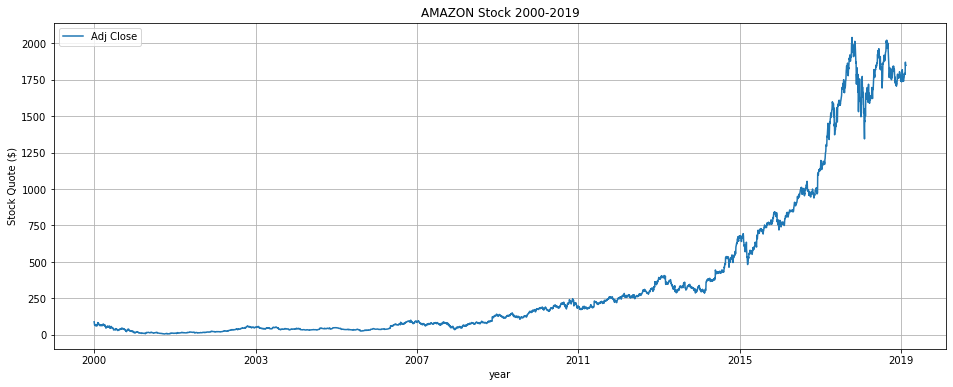

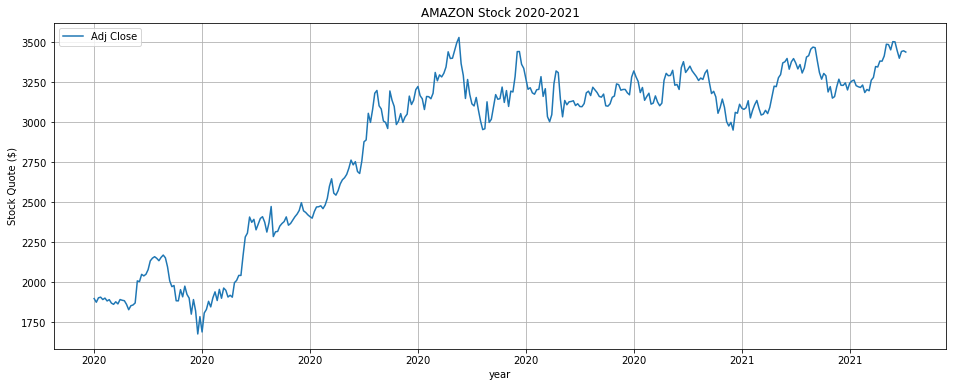

In [147]:
#Both datasets can be visualized using matplotlib, but we must first convert each one to Pandas format with toPandas() method

trainDF_plot = trainDF.select('year', 'Adj Close').toPandas()
trainDF_plot.set_index('year', inplace=True)
trainDF_plot.plot(figsize=(16, 6), grid=True)
plt.title('AMAZON Stock 2000-2019')
plt.ylabel('Stock Quote ($)')
plt.show()

testDF_plot = testDF.select('year', 'Adj Close').toPandas()
testDF_plot.set_index('year', inplace=True)
testDF_plot.plot(figsize=(16, 6), grid=True)
plt.title('AMAZON Stock 2020-2021')
plt.ylabel('Stock Quote ($)')
plt.show()

#### Note how the value of the shares shoots up in early 2020 and stabilizes in the middle of the year, as a result of the pandemic

In [148]:
#Now to normalize our data, we first convert our dataframes to numpy arrays as follows

import numpy as np
trainArray = np.array(trainDF.select('Open', 'High', 'Low','Close','Volume','Adj Close').collect())
testArray = np.array(testDF.select('Open', 'High', 'Low', 'Close','Volume','Adj Close').collect())

In [149]:
print(trainArray[1])

[8.53750e+01 9.15000e+01 8.17500e+01 8.19375e+01 1.74874e+07 8.19375e+01]


In [150]:
print(testArray[1])

[1.86450000e+03 1.88619995e+03 1.86450000e+03 1.87496997e+03
 3.76440000e+06 1.87496997e+03]


In [151]:
from sklearn.preprocessing import MinMaxScaler

In [152]:
#We can leverage the MinMaxScaler() function from sklearn to scale down between 0 and 1 both arrays

minMaxScale = MinMaxScaler()

In [153]:
# The MinMaxScaler() function is fit on the training array (trainArray) and it's then applied to create two brand new arrays:
# trainingArray and testingArray, that are scaled to values between 0 and 1. 
# The first row for each array can be seen in the following:

minMaxScale.fit(trainArray)
testingArray = minMaxScale.transform(testArray)
trainingArray = minMaxScale.transform(trainArray)

In [184]:
#Note how the arrays are now normalized

trainingArray[0]

array([0.03719614, 0.04082494, 0.03663125, 0.04101468, 0.14728477,
       0.04101468])

In [178]:
testingArray[0]

array([0.91973724, 0.92541088, 0.92585269, 0.93041691, 0.03042788,
       0.93041691])

In [154]:
#Now we divide the arrays in such a way that
#The first five elements (i.e Open, High, Low, Close, and Volume) in the arrays will be the features or the x values 
#and the last element (adj close) will be the label or y value

xtrain = trainingArray[:, 0:-1]
xtest = testingArray[:, 0:-1]
ytrain = trainingArray[:, -1:]
ytest = testingArray[:, -1:]

In [186]:
print("Features of the first training element: ",xtrain[0])
print("Label of the first training element:", ytrain[0])
print("Features of the first testing element:", xtest[0])
print("Label of the first testing element:", ytest[0])

Features of the first training element:  [[0.03719614 0.04082494 0.03663125 0.04101468 0.14728477]]
Label of the first training element: [0.04101468]
Features of the first testing element: [[0.91973724 0.92541088 0.92585269 0.93041691 0.03042788]]
Label of the first testing element: [0.93041691]


In [155]:
#the shape of the four arrays that we will be using in the model

print('xtrain shape = {}'.format(xtrain.shape))
print('xtest shape = {}'.format(xtest.shape))
print('ytrain shape = {}'.format(ytrain.shape))
print('ytest shape = {}'.format(ytest.shape))

xtrain shape = (5031, 5)
xtest shape = (377, 5)
ytrain shape = (5031, 1)
ytest shape = (377, 1)


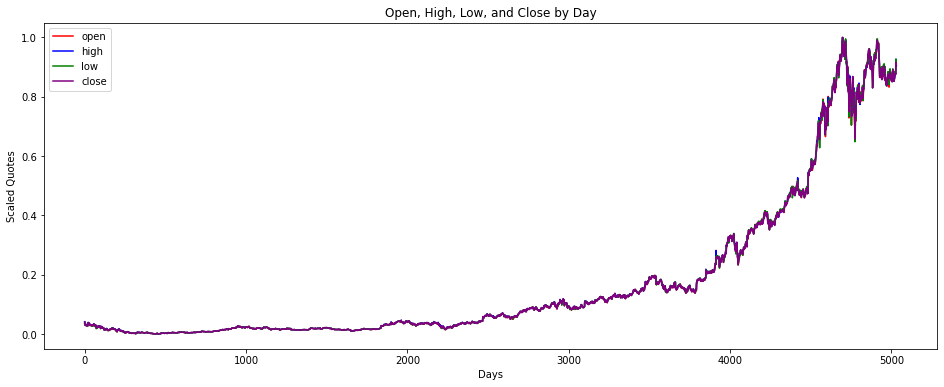

In [156]:
#The values for the training array (xtrain) for open, low, high, and close can be plotted using the newly adjusted scales
#between 0 and 1 for the quotes

plt.figure(figsize=(16,6))
plt.plot(xtrain[:,0],color='red', label='open')
plt.plot(xtrain[:,1],color='blue', label='high')
plt.plot(xtrain[:,2],color='green', label='low')
plt.plot(xtrain[:,3],color='purple', label='close')
plt.legend(loc = 'upper left')
plt.title('Open, High, Low, and Close by Day')
plt.xlabel('Days')
plt.ylabel('Scaled Quotes')
plt.show()

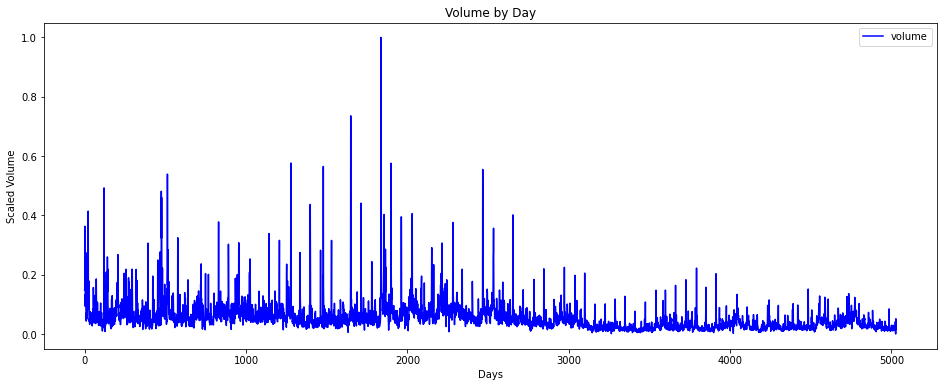

In [157]:
#volume can also be plotted with the scaled volume scores between 0 and 1

plt.figure(figsize=(16,6))
plt.plot(xtrain[:,4],color='blue', label='volume')
plt.legend(loc = 'upper right')
plt.title('Volume by Day')
plt.xlabel('Days')
plt.ylabel('Scaled Volume')
plt.show()

### Building the LSTM Model

In [158]:
#LSTM is an artificial recurrent neural network (RNN) architecture used for time series and more.
#Most of the functionality from keras used to build the LSTM model will come from models and layers
from keras import models, layers

In [159]:
import tensorflow as tf

In [160]:
#The LSTM model has an input_shape = (1,5) for one dependent variable and five independent variables in our training dataset. 
#Only one Dense layer will be used to define the neural network as we are looking to keep the model simple.
#Mean_squared_error calculation is best to determine how close the predicted value is to the actual value.
#An optimizer is also defined, adam has given good results specially in recurrent neural network

model = models.Sequential()
model.add(layers.LSTM(1, input_shape=(1,5)))
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [161]:
#Our current arrays, xtrain and xtest, are currently two-dimensional arrays; however, to incorporate them into the LSTM model, 
#they will need to be converted to three-dimensional arrays using reshape(), as follows
xtrain = xtrain.reshape((xtrain.shape[0], 1, xtrain.shape[1]))
xtest = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))

In [188]:
print('Shape of xtrain is:', xtrain.shape)
print('Shape of xtest is:', xtest.shape)

Shape of xtrain is: (5031, 1, 5)
Shape of xtest is: (377, 1, 5)


In [163]:
#The LSTM model is fit with xtrain and ytrain and the batch size is set to 10 with 100 epochs. 
#The batch size is the setting that defines the number of objects that are trained together.
#And remember an epoch is a measurement of how often the model goes through the entire dataset

loss = model.fit(xtrain, ytrain, batch_size=10, epochs=100)

Epoch 1/100
504/504 [==============================] - 10s 3ms/step - loss: 0.0822
Epoch 2/100
504/504 [==============================] - 2s 4ms/step - loss: 0.0049A: 0s - los
Epoch 3/100
504/504 [==============================] - 2s 3ms/step - loss: 9.4159e-05
Epoch 4/100
504/504 [==============================] - 2s 3ms/step - loss: 7.8742e-05
Epoch 5/100
504/504 [==============================] - 2s 3ms/step - loss: 6.9239e-05
Epoch 6/100
504/504 [==============================] - 1s 3ms/step - loss: 6.7736e-05
Epoch 7/100
504/504 [==============================] - 2s 4ms/step - loss: 6.5567e-05
Epoch 8/100
504/504 [==============================] - 2s 4ms/step - loss: 6.2765e-05
Epoch 9/100
504/504 [==============================] - 2s 4ms/step - loss: 6.4713e-05
Epoch 10/100
504/504 [==============================] - 2s 3ms/step - loss: 6.1946e-05
Epoch 11/100
504/504 [==============================] - 2s 4ms/step - loss: 5.9130e-05
Epoch 12/100
504/504 [==========================

<function matplotlib.pyplot.show(close=None, block=None)>

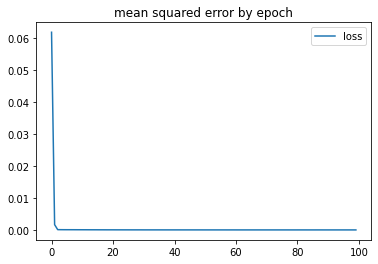

In [164]:
#The mean squared error loss in each epoch is captured and visualized.

plt.plot(loss.history['loss'], label='loss')
plt.title('mean squared error by epoch')
plt.legend()
plt.show

In [165]:
#We can now create a new array, predicted, based on the fitted model applied on xtest 
#and then combine it with ytest to compare them side by side for accuracy purposes
predicted = model.predict(xtest)

In [166]:
combined_array = np.concatenate((ytest, predicted), axis = 1)

### Evaluating the Model

In [167]:
import sklearn.metrics as metrics

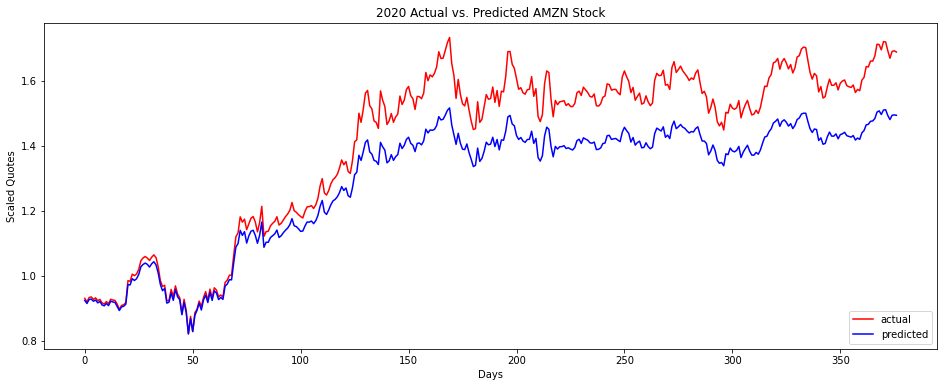

In [168]:
#we can see that our predictions were close to the actual stock quotes from 2020 to 2021, as shown:

plt.figure(figsize=(16,6))
plt.plot(combined_array[:,0],color='red', label='actual')
plt.plot(combined_array[:,1],color='blue', label='predicted')
plt.legend(loc = 'lower right')
plt.title('2020 Actual vs. Predicted AMZN Stock')
plt.xlabel('Days')
plt.ylabel('Scaled Quotes')
plt.show()

In [169]:
#As we can see, we have a mean squared error of 0.1290 or approximately 12.9%
import sklearn.metrics as metrics
np.sqrt(metrics.mean_squared_error(ytest,predicted))

0.12903829219389712